In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib




In [88]:
!pip install seaborn


In [89]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status',
    'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

In [90]:
data = pd.read_csv(url, header=None, names=columns, na_values=' ?', skipinitialspace=True)

In [91]:
print("Data loaded successfully. Shape:", data.shape)
print("\nMissing values before cleaning:")
print(data.isnull().sum())

Data loaded successfully. Shape: (32561, 15)

Missing values before cleaning:
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


In [92]:
for col in ['workclass', 'occupation', 'native-country']:
    data[col] = data[col].fillna(data[col].mode()[0])

In [93]:
data = data.drop(columns=['education'])

In [94]:
data = data[(data['age'] <= 75) & (data['age'] >= 17)]
data = data[(data['educational-num'] <= 16) & (data['educational-num'] >= 5)]

In [95]:
print("\nData shape after cleaning and outlier removal:", data.shape)


Data shape after cleaning and outlier removal: (31163, 14)


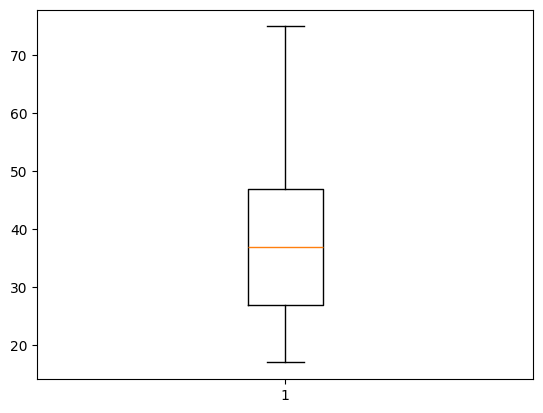

In [96]:
import matplotlib.pyplot as plt   #visualization
plt.boxplot(data['age'])
plt.show()

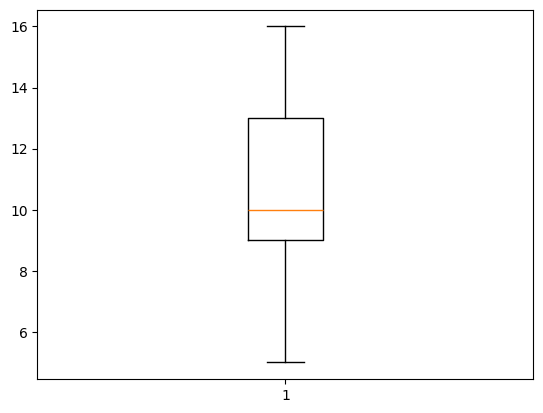

In [97]:
plt.boxplot(data['educational-num'])
plt.show()

In [98]:
X = data.drop('income', axis=1)
y = data['income']

In [99]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [100]:
print("\nTarget classes:", le.classes_)


Target classes: ['<=50K' '>50K']


In [101]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [102]:
print("\nNumeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Features: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


In [103]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [104]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keeps other columns if any
)

In [106]:
from xgboost import XGBClassifier

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [111]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('classifier'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [112]:
y_pred = model_pipeline.predict(X_test)

In [114]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Model Accuracy: {accuracy:.4f}")



✅ Model Accuracy: 0.8696


In [115]:
print("\nClassification Report:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))



Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.91      4685
        >50K       0.77      0.68      0.72      1548

    accuracy                           0.87      6233
   macro avg       0.83      0.81      0.82      6233
weighted avg       0.87      0.87      0.87      6233



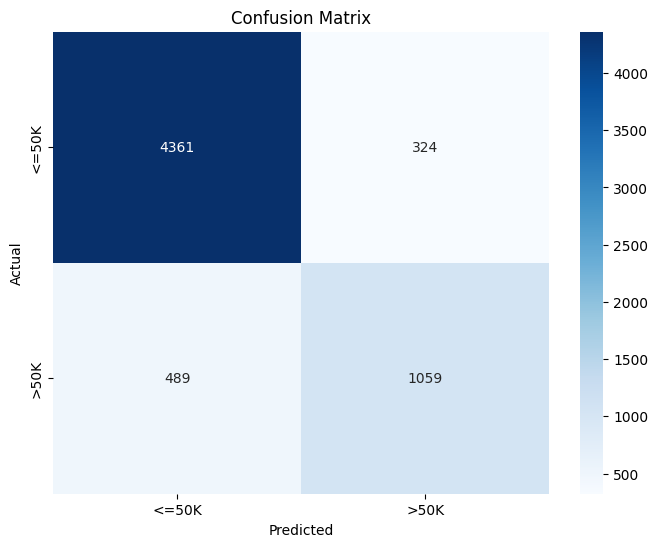

In [116]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [117]:
joblib.dump(model_pipeline, 'salary_prediction_pipeline.pkl', compress=3)
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [118]:
print("\n✅ Pipeline and Label Encoder saved successfully!")
print("   - salary_prediction_pipeline.pkl")
print("   - label_encoder.pkl")


✅ Pipeline and Label Encoder saved successfully!
   - salary_prediction_pipeline.pkl
   - label_encoder.pkl
